Processing all three stablecoin pools...

--- Processing USDC/DAI ---
Standard Hurst Analysis (on Returns):
  Hurst R/S (H): 0.5214
  DFA Hurst (α): 0.2806
Generalized Hurst Analysis (GHE on Prices):
  Generalized Hurst Exponents H(q):
    q=1.0: H(q)=0.3647
    q=2.0: H(q)=0.2526
    q=3.0: H(q)=0.1966
    q=4.0: H(q)=0.1590
    q=5.0: H(q)=0.1331

--- Processing USDT/DAI ---
Standard Hurst Analysis (on Returns):
  Hurst R/S (H): 0.3442
  DFA Hurst (α): 0.5126
Generalized Hurst Analysis (GHE on Prices):
  Generalized Hurst Exponents H(q):
    q=1.0: H(q)=0.1178
    q=2.0: H(q)=0.0150
    q=3.0: H(q)=0.0107
    q=4.0: H(q)=0.0082
    q=5.0: H(q)=0.0066

--- Processing USDC/USDT ---
Standard Hurst Analysis (on Returns):
  Hurst R/S (H): 0.5123
  DFA Hurst (α): 0.3671
Generalized Hurst Analysis (GHE on Prices):
  Generalized Hurst Exponents H(q):
    q=1.0: H(q)=0.3319
    q=2.0: H(q)=0.0712
    q=3.0: H(q)=0.0122
    q=4.0: H(q)=0.0044
    q=5.0: H(q)=0.0033

Creating combined analysis 

<IPython.core.display.Javascript object>


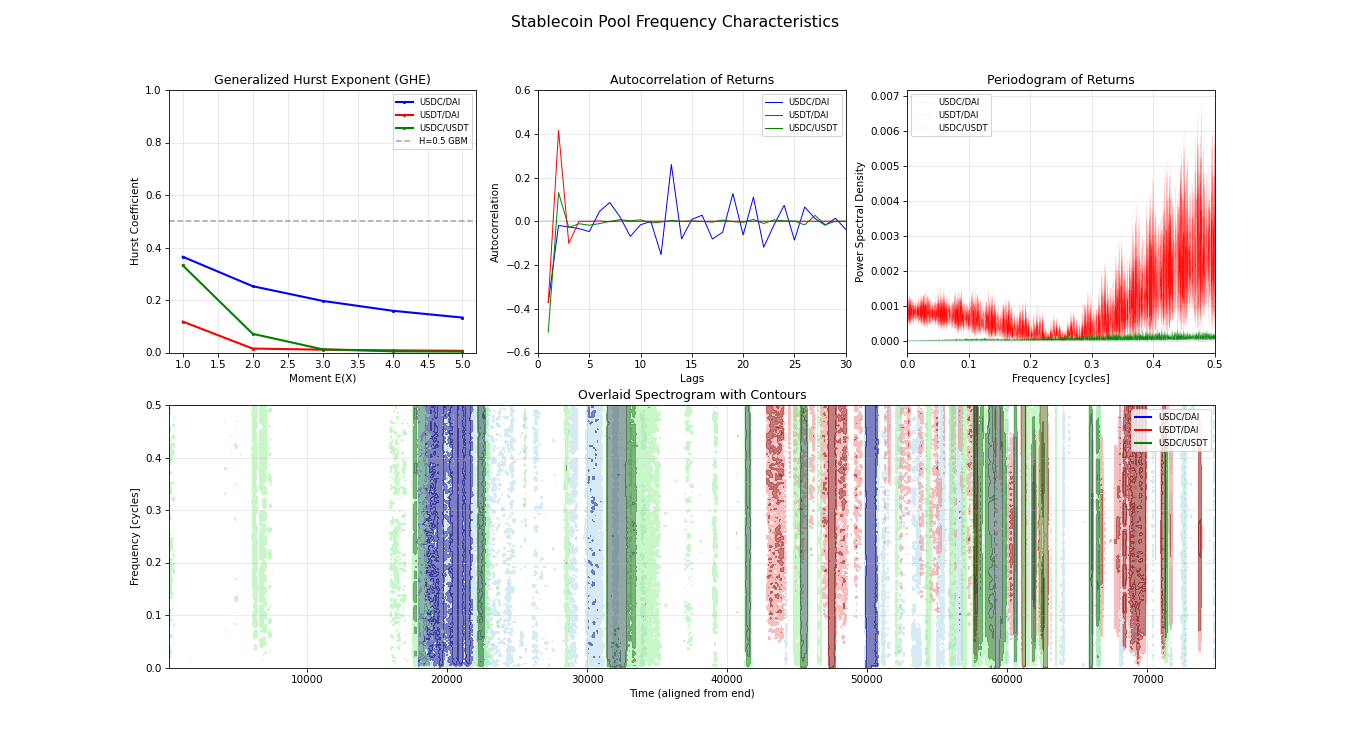


--- SUMMARY COMPARISON ---
Generalized Hurst Exponents by Pool:

USDC/DAI:
  q=1.0: H(q)=0.3647
  q=2.0: H(q)=0.2526
  q=3.0: H(q)=0.1966
  q=4.0: H(q)=0.1590
  q=5.0: H(q)=0.1331

USDT/DAI:
  q=1.0: H(q)=0.1178
  q=2.0: H(q)=0.0150
  q=3.0: H(q)=0.0107
  q=4.0: H(q)=0.0082
  q=5.0: H(q)=0.0066

USDC/USDT:
  q=1.0: H(q)=0.3319
  q=2.0: H(q)=0.0712
  q=3.0: H(q)=0.0122
  q=4.0: H(q)=0.0044
  q=5.0: H(q)=0.0033


C:\Users\q6435\AppData\Local\Temp\ipykernel_32492\143205914.py:80: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, alpha=0.3)
C:\Users\q6435\AppData\Local\Temp\ipykernel_32492\143205914.py:108: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, alpha=0.3)
C:\Users\q6435\AppData\Local\Temp\ipykernel_32492\143205914.py:128: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, alpha=0.3)
C:\Users\q6435\AppData\Local\Temp\ipykernel_32492\143205914.py:219: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, alpha=0.3)


In [37]:

import numpy as np
import pandas as pd
import nolds
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from sklearn.preprocessing import StandardScaler
from typing import Optional, Tuple
import scipy.signal
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap

"""
Stablecoin signal processing

Stablecoin pools:
    USDC_DAI_uniswap_0x5777d92f208679DB4b9778590Fa3CAB3aC9e2168
    USDT_DAI_uniswap_0x48da0965ab2d2cbf1c17c09cfb5cbe67ad5b1406
    USDC_USDT_uniswap_0x3416cF6C708Da44DB2624D63ea0AAef7113527C6   
"""

title1='USDC_DAI_uniswap_0x5777d92f208679DB4b9778590Fa3CAB3aC9e2168'
title2='USDT_DAI_uniswap_0x48da0965ab2d2cbf1c17c09cfb5cbe67ad5b1406'
title3='USDC_USDT_uniswap_0x3416cF6C708Da44DB2624D63ea0AAef7113527C6'

pool_data = [
    (title1, 'USDC/DAI'),
    (title2, 'USDT/DAI'), 
    (title3, 'USDC/USDT')
]

colors = ['blue', 'red', 'green']

def calculate_generalized_hurst(time_series: pd.Series, 
                                qvals: np.ndarray, 
                                fit: str = 'poly', 
                                debug_plot: bool = False) -> Optional[np.ndarray]:
    try:
        if not isinstance(time_series, (pd.Series, np.ndarray)):
            raise ValueError("Input must be a pandas Series or numpy array.")
        
        # Prepare data: convert to float array, remove NaNs
        ts = np.asarray(time_series).astype(float)
        ts = ts[~np.isnan(ts)]
        
        if len(ts) < 100:
            raise ValueError(f"Time series must have at least 100 data points, found {len(ts)}")
            
        # Standardize the time series (essential for comparing fluctuation scales in GHE)
        scaler = StandardScaler()
        ts_scaled = scaler.fit_transform(ts.reshape(-1, 1)).flatten()
        
        # Calculate Multifractal Hurst (GHE)
        mfhurst = nolds.mfhurst_b(ts_scaled, qvals=qvals, fit=fit, debug_plot=debug_plot, debug_data=False)
        return mfhurst
    
    except ValueError as ve:
        print(f"ValueError during GHE calculation: {ve}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during GHE calculation: {e}")
        return None

def plot_hurst_subplot(ax, q_values, results_list, labels, colors):
    """Plot Generalized Hurst Exponent on given axis."""
    for i, (mfhurst, label) in enumerate(zip(results_list, labels)):
        if mfhurst is not None:
            valid_mask = ~np.isnan(mfhurst)
            valid_q_values = q_values[valid_mask]
            valid_mfhurst = mfhurst[valid_mask]
            
            ax.plot(valid_q_values, valid_mfhurst, 
                   color=colors[i], lw=2, marker='o', markersize=2,
                   label=label)
    
    ax.axhline(0.5, color='gray', linestyle='--', 
               label='H=0.5 GBM', alpha=0.7)
    ax.set_title('Generalized Hurst Exponent (GHE)')
    ax.set_xlabel('Moment E(X)')
    ax.set_ylabel('Hurst Coefficient')
    ax.set_ylim(0, 1)
    ax.legend(fontsize=8)
    ax.grid(False, alpha=0.3)

def plot_autocorr_subplot(ax, returns_list, labels, colors):
    """Plot Autocorrelation Function on given axis."""
    lag_count = 30
    
    for i, (returns, label) in enumerate(zip(returns_list, labels)):
        if returns is not None and len(returns) > lag_count:
            try:
                acf_values, confint = sm.tsa.acf(returns, nlags=lag_count, fft=True, alpha=0.85)
                ax.plot(range(1, len(acf_values)), acf_values[1:], 
                       linestyle='-', lw=0.95, color=colors[i], label=label)
                
                # Add confidence intervals for first dataset only (to avoid clutter)
                if i == 0:
                    for j in range(1, len(confint)):
                        ax.fill_between([j, j], confint[j, 0] - acf_values[j], 
                                      confint[j, 1] - acf_values[j], alpha=0.85, color=colors[i])
            except Exception as e:
                print(f"Error calculating ACF for {label}: {e}")
    
    ax.axhline(y=0, linestyle='--', lw=0.25, color='k')
    ax.set_title('Autocorrelation of Returns')
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation")
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(0, lag_count)
    ax.legend(fontsize=8)
    ax.grid(False, alpha=0.3)

def plot_periodogram_subplot(ax, returns_list, labels, colors):
    """Plot Periodogram on given axis."""
    fs = 1  # 1 sample per day
    
    for i, (returns, label) in enumerate(zip(returns_list, labels)):
        if returns is not None and len(returns) > 10:
            try:
                data_signal = np.power(returns, 1)  # Equivalent to returns
                f, S = scipy.signal.periodogram(data_signal, fs, scaling='density')
                ax.plot(f, S, lw=0.05, color=colors[i], label=label, alpha=0.95)
            except Exception as e:
                print(f"Error calculating periodogram for {label}: {e}")
    
    ax.set_xlabel('Frequency [cycles]')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title('Periodogram of Returns')
    ax.set_xlim(0, 0.5)
    ax.legend(fontsize=8)
    ax.grid(False, alpha=0.3)

def create_custom_colormaps():
    """Create custom colormaps for each dataset."""
    # Blue-based colormap for USDC/DAI
    blues_colors = ['white', 'lightblue', 'blue', 'darkblue', 'navy']
    blue_cmap = LinearSegmentedColormap.from_list('custom_blues', blues_colors)
    
    # Red-based colormap for USDT/DAI  
    reds_colors = ['white', 'lightcoral', 'red', 'darkred', 'maroon']
    red_cmap = LinearSegmentedColormap.from_list('custom_reds', reds_colors)
    
    # Green-based colormap for USDC/USDT
    greens_colors = ['white', 'lightgreen', 'green', 'darkgreen', 'darkslategray']
    green_cmap = LinearSegmentedColormap.from_list('custom_greens', greens_colors)
    
    return [blue_cmap, red_cmap, green_cmap]

def plot_spectrogram_subplot(ax, returns_list, labels, colors):
    """Plot overlaid spectrograms using contours with distinct color schemes."""
    fs = 1  # 1 sample per day
    
    # Create custom colormaps
    cmaps = create_custom_colormaps()
    
    # Find the maximum length to align all time series from the end
    max_length = max(len(returns) for returns in returns_list if returns is not None)
    
    plotted_any = False
    
    for i, (returns, label) in enumerate(zip(returns_list, labels)):
        if returns is not None and len(returns) > 100:
            try:
                data_signal = np.power(returns, 1)  # Equivalent to returns
                
                # Calculate appropriate segment size
                nperseg = min(256, len(data_signal)//4)
                noverlap = nperseg//2
                
                if nperseg < 8:
                    continue
                    
                f, t, Sxx = scipy.signal.spectrogram(data_signal, fs=fs, 
                                                   nperseg=nperseg, 
                                                   noverlap=noverlap)
                
                # Align time series from the end (most recent data)
                time_offset = max_length - len(data_signal)
                t_aligned = t + time_offset
                
                # Convert to dB and handle log issues
                Sxx_db = 10 * np.log10(Sxx + 1e-10)
                
                # Use contour plots for better overlay visualization
                contour_levels = np.linspace(np.percentile(Sxx_db, 20), 
                                           np.percentile(Sxx_db, 95), 8)
                
                # Plot contours with dataset-specific colors
                cs = ax.contour(t_aligned, f, Sxx_db, levels=contour_levels, 
                               colors=[colors[i]], linewidths=0.01, alpha=0.13)
                
                # Add filled contours for the highest intensity regions
                high_levels = np.linspace(np.percentile(Sxx_db, 80), 
                                        np.percentile(Sxx_db, 95), 3)
                cs_fill = ax.contourf(t_aligned, f, Sxx_db, levels=high_levels, 
                                    cmap=cmaps[i], alpha=0.5, extend='max')
                
                plotted_any = True
                    
            except Exception as e:
                print(f"Error creating spectrogram for {label}: {e}")
    
    # If no spectrograms were created, show message
    if not plotted_any:
        ax.text(0.5, 0.5, 'Spectrograms unavailable\n(insufficient data)', 
               ha='center', va='center', transform=ax.transAxes)
    
    ax.set_ylabel('Frequency [cycles]')
    ax.set_xlabel('Time (aligned from end)')
    ax.set_title('Overlaid Spectrogram with Contours')
    ax.set_ylim(0, 0.5)
    
    # Create custom legend
    legend_elements = []
    for i, label in enumerate(labels):
        if returns_list[i] is not None and len(returns_list[i]) > 100:
            legend_elements.append(plt.Line2D([0], [0], color=colors[i], lw=2, label=label))
    
    if legend_elements:
        ax.legend(handles=legend_elements, fontsize=8, loc='upper right')
    
    ax.grid(False, alpha=0.3)

# Process all three datasets
print("Processing all three stablecoin pools...\n")

q_values = np.arange(1, 6, 1)
mfhurst_results = []
returns_list = []
pool_labels = []
hurst_data = {}

for i, (title, short_label) in enumerate(pool_data):
    print(f"--- Processing {short_label} ---")
    
    try:
        # Load and process data
        df_pool = pd.read_csv('data_euler/'+title+'.csv')
        df_pool['evt_block_time'] = pd.to_datetime(df_pool['evt_block_time'], utc=True)
        
        # Sort by time to ensure proper chronological order
        df_pool = df_pool.sort_values('evt_block_time')
        
        column_select = 'price'
        df_pool['Price'] = pd.to_numeric(df_pool[column_select], errors='coerce')
        df_pool['Returns'] = df_pool[column_select].pct_change(1)
        df_pool['Date'] = df_pool['evt_block_time']
        
        close_prices = df_pool['Price']
        close_returns = df_pool['Price'].pct_change().dropna()
        
        # Store returns for other plots
        returns_list.append(close_returns)
        
        # Calculate standard Hurst measures
        print(f"Standard Hurst Analysis (on Returns):")
        H_RS = nolds.hurst_rs(close_returns)
        print(f"  Hurst R/S (H): {H_RS:.4f}")
        DFA_H = nolds.dfa(close_returns)
        print(f"  DFA Hurst (α): {DFA_H:.4f}")
        
        # Calculate Generalized Hurst
        print(f"Generalized Hurst Analysis (GHE on Prices):")
        mfhurst = calculate_generalized_hurst(close_prices, qvals=q_values, debug_plot=False)
        
        if mfhurst is not None:
            print("  Generalized Hurst Exponents H(q):")
            for q, h_q in zip(q_values, mfhurst):
                print(f"    q={q:.1f}: H(q)={h_q:.4f}")
            
            mfhurst_results.append(mfhurst)
            hurst_data[short_label] = mfhurst
        else:
            print(f"  Failed to calculate GHE for {short_label}")
            mfhurst_results.append(None)
        
        pool_labels.append(short_label)
        
    except Exception as e:
        print(f"Error processing {short_label}: {e}")
        mfhurst_results.append(None)
        returns_list.append(None)
        pool_labels.append(short_label)
    
    print()

fig = plt.figure(figsize=(18, 10))
ax1 = plt.subplot2grid((2, 3), (0, 0))  # Top left
ax2 = plt.subplot2grid((2, 3), (0, 1))  # Top center  
ax3 = plt.subplot2grid((2, 3), (0, 2))  # Top right
ax4 = plt.subplot2grid((2, 3), (1, 0), colspan=3)  # Bottom spanning all columns
fig.suptitle('Stablecoin Pool Frequency Characteristics', fontsize=15)
plot_hurst_subplot(ax1, q_values, mfhurst_results, pool_labels, colors)
plot_autocorr_subplot(ax2, returns_list, pool_labels, colors)
plot_periodogram_subplot(ax3, returns_list, pool_labels, colors)
plot_spectrogram_subplot(ax4, returns_list, pool_labels, colors)
plt.show()
